The purpose of this notebook is to compare `librosa`'s mel spectrogram encoding with `kapre`'s mel spectrogram encoding.

`kapre`'s mel spectrogram encoding happens on the GPU, and is used in the same way as a keras layer. A simple model was created with the `kapre` layer,
and a sample was ran through it. The output of the mel spectrogram layer was taken and converted back into audio. The results are a much noiser signal than
`librosa`'s mel spectrogram encoding. Therefore, going forward `kapre` will not be used.

In [1]:
from typing import Tuple

import numpy as np
from kapre.composed import get_melspectrogram_layer
from librosa import load
from librosa.feature import melspectrogram
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential

import utils.constants as consts
from utils.audio_tools import create_audio_player
from utils.displays import display_mel_spectrogram

# Load sample.
path_to_audio: str = '/media/audio/string_segment.wav'
sample: np.ndarray = load(path_to_audio)[0]

#### Librosa encoding and back to audio

Encoded sample shape: (300, 44)


<Figure size 640x480 with 0 Axes>

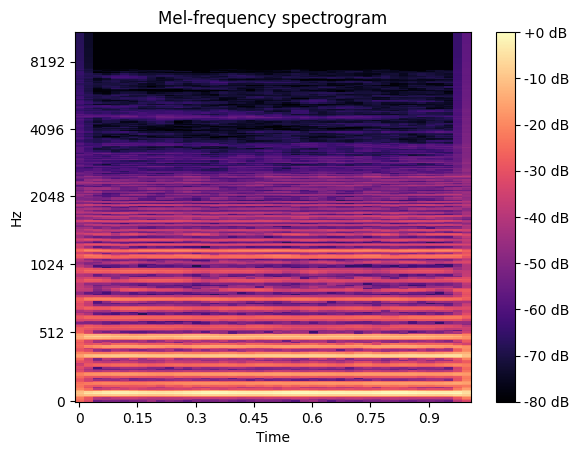

Pre-encoding sample:


Post-encoding sample:


In [2]:
encoded_sample: np.ndarray = melspectrogram(
    y=sample,
    sr=consts.SAMPLE_RATE,
    n_fft=consts.NUM_FFT,
    hop_length=consts.MEL_HOP_LEN,
    n_mels=consts.NUM_MELS,
    win_length=consts.MEL_WINDOW_LEN
)

print(f'Encoded sample shape: {encoded_sample.shape}')
display_mel_spectrogram(encoded_sample)

print('Pre-encoding sample:')
create_audio_player(sample, normalize=True)

print('Post-encoding sample:')
create_audio_player(encoded_sample, normalize=True)

Reshape data for Kapre

In [3]:
reshaped_sample: np.ndarray = sample.reshape((1, -1, 1))
print(reshaped_sample.shape)

(1, 22050, 1)
(1, 300, 44, 1)


#### Create small model with mel spectrogram layer

In [4]:
input_shape: Tuple[int, int] = (consts.SAMPLE_RATE, 1)

# Encoding layer.
composed_mel_spec_layer: Sequential = get_melspectrogram_layer(
    input_shape=input_shape,
    n_fft=consts.NUM_FFT,
    win_length=consts.MEL_WINDOW_LEN,
    hop_length=consts.MEL_HOP_LEN,
    n_mels=consts.NUM_MELS,
    sample_rate=consts.SAMPLE_RATE,
    mel_norm=500,
    pad_end=True,
    pad_begin=False,
    input_data_format='channels_last',
    output_data_format='channels_last',
)

# input_layer = Input(shape=(consts.NUM_MELS, 44, 1))

output = Dense(1, activation=softmax, name='output')(composed_mel_spec_layer.output)
model = Model(inputs=composed_mel_spec_layer.input, outputs=output, name='kapre_test_model')

model.summary()

Model: "kapre_test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft_input (InputLayer)      [(None, 22050, 1)]        0         
_________________________________________________________________
stft (STFT)                  (None, 44, 1025, 1)       0         
_________________________________________________________________
magnitude (Magnitude)        (None, 44, 1025, 1)       0         
_________________________________________________________________
apply_filterbank (ApplyFilte (None, 44, 300, 1)        0         
_________________________________________________________________
output (Dense)               (None, 44, 300, 1)        2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### Run sample through model and convert it into an audio signal

(300, 44)


<Figure size 640x480 with 0 Axes>

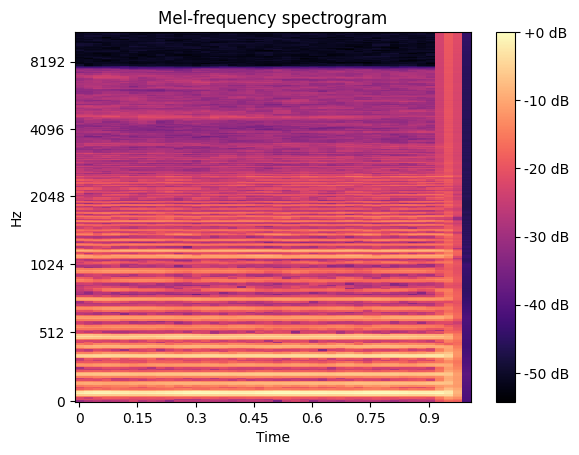

In [5]:
layer_name: str = 'apply_filterbank'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output: np.ndarray = intermediate_layer_model(reshaped_sample).numpy().reshape(44, 300).transpose()

print(intermediate_output.shape)
display_mel_spectrogram(intermediate_output)
create_audio_player(intermediate_output, normalize=True)